In [178]:
#basic
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#interactive plot
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Note: After opening this nb, Re-Run all the cells first to properly display the interactive plots in the notebook
### If notebook is showing error or if plots are not showing, then a html version of this notebook with all the plots and codes is also provided .


### Objective

This Project might help Organizations like RBI to Understand the demand and flow of Liquidity in the Indian Market and help them to forecast it so that they can inform and help Small Banks to make better stategies about refilling cash in their ATM's.

#### Data Collection

We got real world ‘ATM withdrawal value across banks’data from RBI website. The data is dated from 01/06/2020 till 18/04/2021. Source: https://www.rbi.org.in/Scripts/BS_PressReleaseDisplay.aspx?prid=49901

In [179]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [180]:
df = pd.read_excel('rbidataset.xls', parse_dates=['Date'], index_col='Date')
data = df['Value']
data.head()

Date
2020-06-01    696.561179
2020-06-02    676.752623
2020-06-03    668.884848
2020-06-04    648.922639
2020-06-05    646.989160
Name: Value, dtype: float64

# <u> Exploring Data (EDA) </u>

In [181]:
fig = px.line(data, height=400, title='Original Data Plot')
fig.show()

- Daily data from June 2020 to April 2021
- No evident overall long-term trend by looking at plot
- there seems to be cyclicity 
- There is seasonality which  seems to be multiplicative as the net seasonal amplitudes seems to vary 

In [182]:
data.shape

(322,)

In [183]:
train = data[:-90]
valid = data[-90:-45]
test = data[-45:] 

In [184]:
train.tail()

Date
2021-01-14    649.62
2021-01-15    713.04
2021-01-16    701.67
2021-01-17    495.88
2021-01-18    768.14
Name: Value, dtype: float64

In [185]:
valid.head()

Date
2021-01-19    724.16
2021-01-20    707.24
2021-01-21    686.03
2021-01-22    685.91
2021-01-23    626.48
Name: Value, dtype: float64

In [186]:
test.shape, valid.shape

((45,), (45,))

In [187]:
train.shape

(232,)

In [188]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train.values,
#                     mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=test.index,y=test.values,
                    mode='lines',
                    name='test'))
fig.add_trace(go.Scatter(x=valid.index,y=valid.values,
                    mode='lines',
                    name='valid'))


fig.update_layout(height=400,
                 title='Train and Test Division')
fig.show()

## Manual method to know trend and seasonality using ACF (Decomposition)

- Any time series can be decomposed into 3 components: trend-cycle(long-term movements), seasonality(periodic movements) and residuals(short-term fluctuations). Since it is difficult to estimate trend and cycle components separately, we usually combine trend and cycle into one trend-cycle component. In any kind of decomposition trend and cycle come together 


- There are two ways in which we can decompose the time series:
  - Multiplicative : y(t) = T(t) * S(t) * R(t)
  - Additive : y(t) = T(t) + S(t) + R(t)


- In a multiplicative time series, the decomposed components multiply together to make the time series. In a multiplicative series, the amplitude of seasonal activity increases and everything becomes more exaggerated. Multiplicative trend looks more like an exponential curve and multiplicative seasonality has waves that grow in amplitude of the course of time.

- In an additive model we assume the componenents of the time series have an additive effect, that the amplitude of the seasonal effect is roughly the same

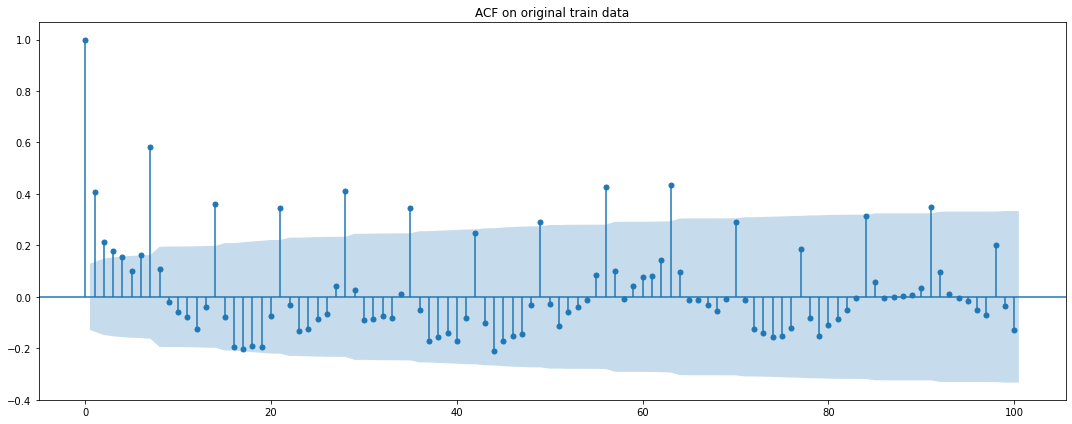

In [189]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(15,6))
plot_acf(train, ax=plt.gca(),lags=100) 
plt.title('ACF on original train data')
plt.show()

- There are peaks in ACF at 7,14,21....(regular intervals) which may indicate weekly seasonality (lag7 seasonality)
- When data are seasonal, the autocorrelations will be larger for the seasonal lags (at multiples of the seasonal frequency) than for other lags.


- There seems to be presence of trend-cycle as well
- When data have a trend-cycle, the autocorrelations for small lags tend to be large and positive because observations nearby in time are also nearby in size. So the ACF of trended time series tend to have positive values that slowly decrease as the lags increase.


- Now we will de-trend the data by taking the first differences , to know exactly about the seasonality by plotting ACF

In [190]:
diff1 = train.diff(1).dropna() #initial de-trending

In [191]:
fig = px.line(diff1, height=400, title='Lag1 Data Plot of train (de-trended)')
fig.show()

- no visible trend now
- clearly amplitude of seasonality is varying 

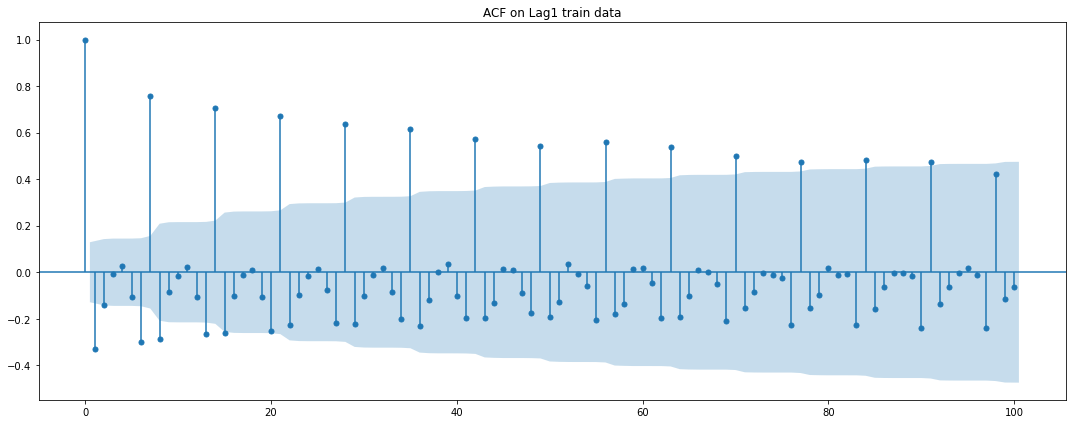

In [192]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(15,6))
plot_acf(diff1, ax=plt.gca(),lags=100) 
plt.title('ACF on Lag1 train data')
plt.show()

- Clearly there is a weekly periodicity as expected , so we will use a window size of 7 
- Now we will remove seasonlity by taking a lag7 to get other patterns

In [193]:
diff7 = train.diff(7).dropna() #de-seasoning

In [194]:
fig = px.line(diff7, height=400, title='Lag7 Data Plot of train(de-seasoned)')
fig.show()

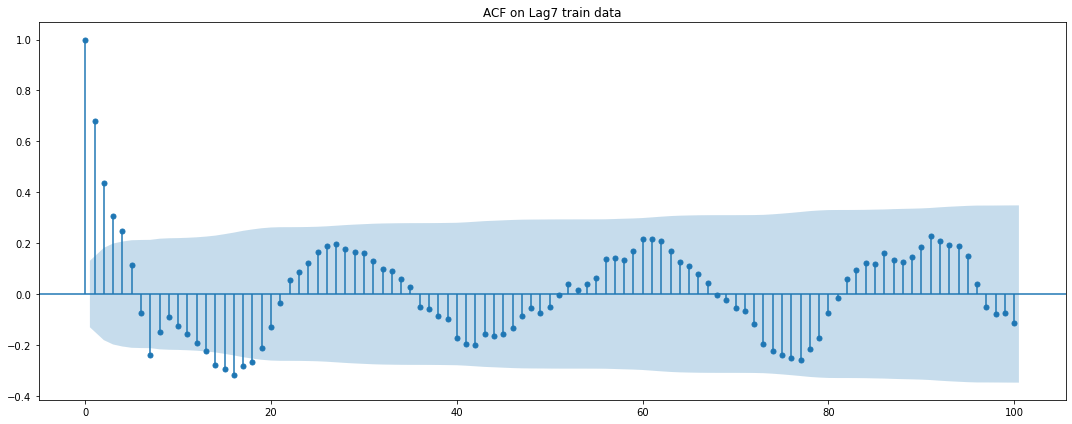

In [195]:
plt.figure(figsize=(15,6))
plot_acf(diff7, ax=plt.gca(),lags=100) 
plt.title('ACF on Lag7 train data')
plt.show()

- This gradual decaying pattern depicts presence of trend-cycle

## Simple Moving Average

- Moving Average smoothing is the process of removing coarseness in a plot of raw time series data.
- Thus most common use of simple moving averages is for estimating the trend-cycle from seasonal data. 
- We can smooth out seasonal patterns by setting the length of our moving average to equal the pattern’s length. If there is no seasonal pattern in our data, we choose a length that makes sense. Longer lengths will produce smoother lines.
- i.e 7-MA can be used to estimate the trend-cycle of daily data with a weekly(lag7) seasonality.

In [196]:
window = 7 #seasonal lag
moving_avg_7 = train.rolling(window).mean() #taking a rolling mean with window=seasonal lag estimates trend-cycle
moving_avg_3 = train.rolling(3).mean()
moving_avg_11 = train.rolling(11).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train.values,
                    mode='lines',
                    name='Orignal Series'))
fig.add_trace(go.Scatter(x=moving_avg_7.index,y=moving_avg_7.values,
                    mode='lines',
                    name='Moving Avg (trend-cycle)'))

fig.update_layout(height=400,
                 title=f'Moving Average Fit with window = {window}')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=moving_avg_3.index,y=moving_avg_3.values,opacity=0.7,
                    mode='lines',
                    name='Moving Avg 3'))
fig.add_trace(go.Scatter(x=moving_avg_7.index,y=moving_avg_7.values,
                    mode='lines',
                    name='Moving Avg 7'))
fig.add_trace(go.Scatter(x=moving_avg_11.index,y=moving_avg_11.values,opacity=0.7,
                    mode='lines',
                    name='Moving Avg 11'))

fig.update_layout(height=400,
                 title=f'Comparision of moving averages window')
fig.show()

## STL decomposition (auto trend and seasonality)
- Seasonality decompostion is an analysis tool that provides us a framework for how to think about the different components of our time series. We can decompose our series to understand the influence of each component and use that to guide our data preparation, model selection, and model tuning.

In [197]:
from statsmodels.tsa.seasonal import STL

In [198]:
stl = STL(train)
decomposition = stl.fit()
# decomposition = sts.seasonal_decompose(train)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = make_subplots(4,1,subplot_titles=['Original','Trend-Cycle','Seasonality','Residuals'],shared_xaxes=True)
fig.add_trace(go.Scatter(x=train.index,y=train.values,
                    mode='lines',
                    name='Original'),row=1,col=1)
fig.add_trace(go.Scatter(x=trend.index,y=trend.values,
                    mode='lines',
                    name='trend'),row=2,col=1)
fig.add_trace(go.Scatter(x=seasonal.index,y=seasonal.values,
                    mode='lines',
                    name='season'),row=3,col=1)
fig.add_trace(go.Scatter(x=residual.index,y=residual.values,
                    mode='lines',
                    name='residual'),row=4,col=1)
fig.update_layout(height=800, title='STL Decomposition',showlegend=False)
fig.show()

- It dosent look like trend-cycle has actually trend, but seems to have mainly cyclicity only
- Seasonality is present with varying amplitude

# <u> Forecasting </u>

## Weighted Average Models
- although we know data has both trend and seasonality but still we are trying simpler models for baselines

In [199]:
import statsmodels.api as sm

In [200]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [201]:
train = train.astype('double')
ses = SimpleExpSmoothing(train).fit()
ses1 = ses.forecast(len(valid))
ses.summary()

Dep. Variable:,Value,No. Observations:,232
Model:,SimpleExpSmoothing,SSE,3667974.074
Optimized:,True,AIC,2247.072
Trend:,None,BIC,2253.965
Seasonal:,None,AICC,2247.248
Seasonal Periods:,None,Date:,"Sun, 22 Aug 2021"
Box-Cox:,False,Time:,13:58:32
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2279055,alpha,True
initial_level,682.73428,l.0,True


In [202]:
from statsmodels.tsa.stattools import adfuller
import scipy.stats as sp
def resid_summary(resid):
    
    dftest = adfuller(resid)
    p_value = dftest[1]
    
    fig = plt.figure(figsize=(15,8))
    
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
    ax3 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
    ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
    ax5 = plt.subplot2grid((3, 2), (2, 1), colspan=1)
    
    
    ax1.plot(resid)
    ax1.set_title(f'Residual Plot | ADF Test p-value: {p_value}')
    
    plot_acf(resid, lags=40, ax=ax2) 
    
    plot_pacf(resid, lags=40, ax=ax3)  
    
    ax4.hist(resid, density=1, bins=50)
    resid.plot.kde(ax=ax4)
    ax4.set_title('Distribution Plot of residuals')
    
    sp.probplot(resid, plot=ax5)
    ax5.set_title('QQ Plot of residuals')
    
    plt.tight_layout()
    


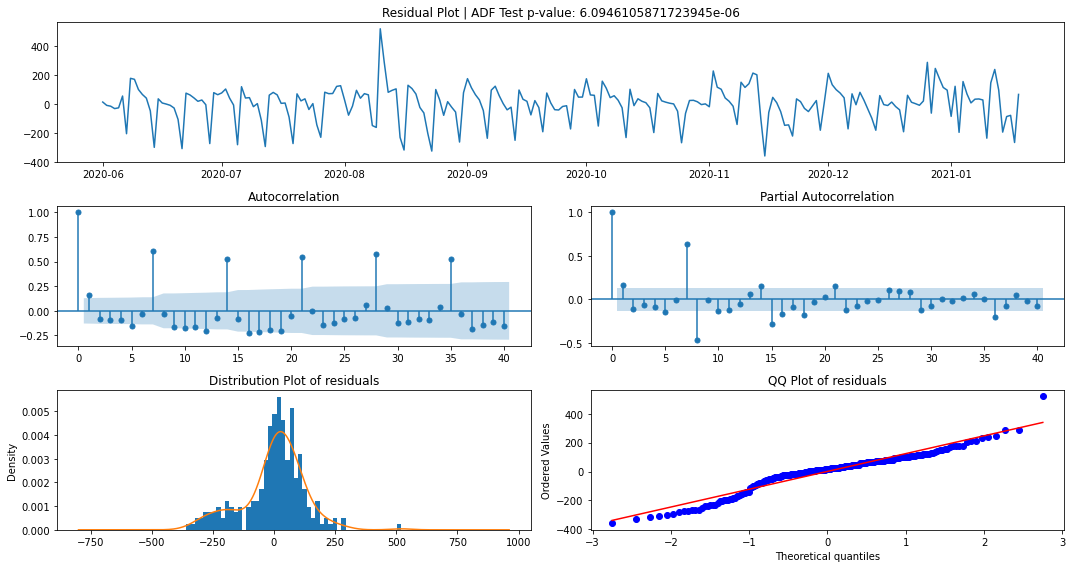

In [203]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train.values,
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=ses1.index,y=ses1.values,opacity=0.6,
                    mode='lines',
                    name='predicted'))
fig.add_trace(go.Scatter(x=valid.index,y=valid.values,opacity=0.6,
                    mode='lines',
                    name='valid'))
fig.update_layout(height=400,
                 title=f'Simple Exponential Smoothing Fit')
fig.show()
resid_summary(ses.resid) #for single exp smoothing

- very bad fit
- We will use this as baseline model

A good forecasting method will yield residuals with the following properties:

- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean  
m
 , then simply add  
m
  to all forecasts and the bias problem is solved. Fixing the correlation problem is harder
  
In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

- The residuals have constant variance.
- The residuals are normally distributed.


These two properties make the calculation of prediction intervals easier (see Section 3.5 for an example). However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary

In [204]:
model_compare_list = [] 

In [205]:
def get_metrics(y_true, y_pred):
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    return rmse,mape

In [206]:
model_compare_list.append(['Single Exponential', *get_metrics(valid, ses1)])
model_compare_list[-1]

['Single Exponential', 123.496698847027, 16.82649131870121]

### Double Exponential Smoothing (Holts)

In [207]:
hes = ExponentialSmoothing(train, trend='add').fit()
hes1 = hes.forecast(len(valid))
hes.summary()

Dep. Variable:,Value,No. Observations:,232
Model:,ExponentialSmoothing,SSE,3763383.140
Optimized:,True,AIC,2257.029
Trend:,Additive,BIC,2270.816
Seasonal:,None,AICC,2257.403
Seasonal Periods:,None,Date:,"Sun, 22 Aug 2021"
Box-Cox:,False,Time:,13:58:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2880633,alpha,True
smoothing_trend,0.0252283,beta,True


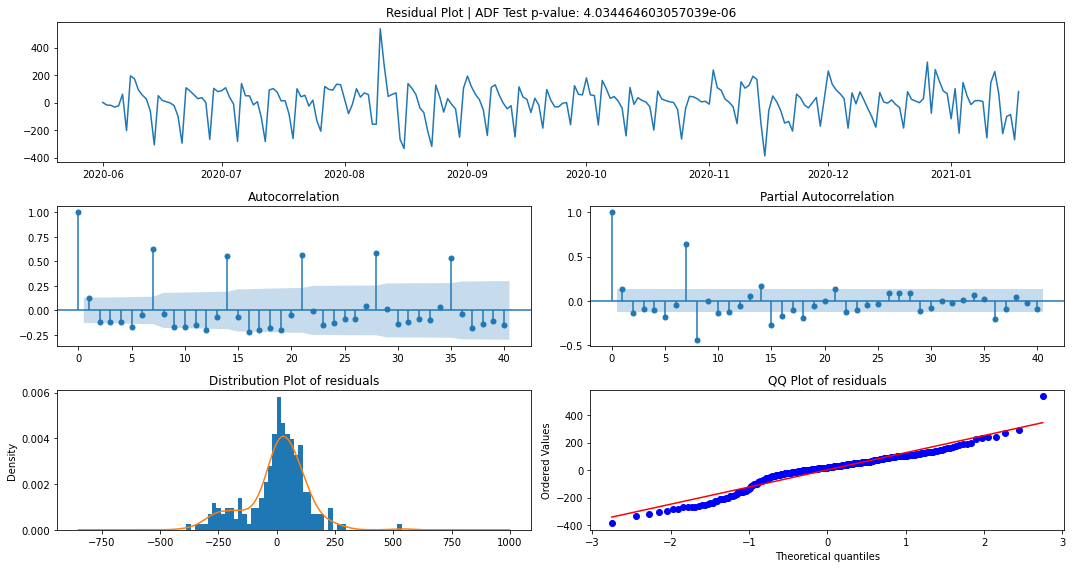

In [208]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train.values,
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=hes1.index,y=hes1.values,opacity=0.6,
                    mode='lines',
                    name='predicted'))
fig.add_trace(go.Scatter(x=valid.index,y=valid.values,opacity=0.6,
                    mode='lines',
                    name='test'))
fig.update_layout(height=400,
                 title=f'Double Exponential Smoothing Fit (Holt)')
fig.show()
resid_summary(hes.resid)

- still bad

In [209]:
model_compare_list.append(['Double Exponential', *get_metrics(valid,hes1)])
model_compare_list[-1]

['Double Exponential', 134.2115181237917, 18.209345086778576]

### Triple Exponential (Holt-Winter)

In [210]:
hwes = ExponentialSmoothing(train , seasonal_periods=7 ,trend='add', seasonal="mul").fit()
hwes1 = hwes.forecast(len(valid))
hwes.summary()

Dep. Variable:,Value,No. Observations:,232
Model:,ExponentialSmoothing,SSE,1216790.943
Optimized:,True,AIC,2009.078
Trend:,Additive,BIC,2046.992
Seasonal:,Multiplicative,AICC,2010.747
Seasonal Periods:,7,Date:,"Sun, 22 Aug 2021"
Box-Cox:,False,Time:,13:58:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5059496,alpha,True
smoothing_trend,0.0272311,beta,True


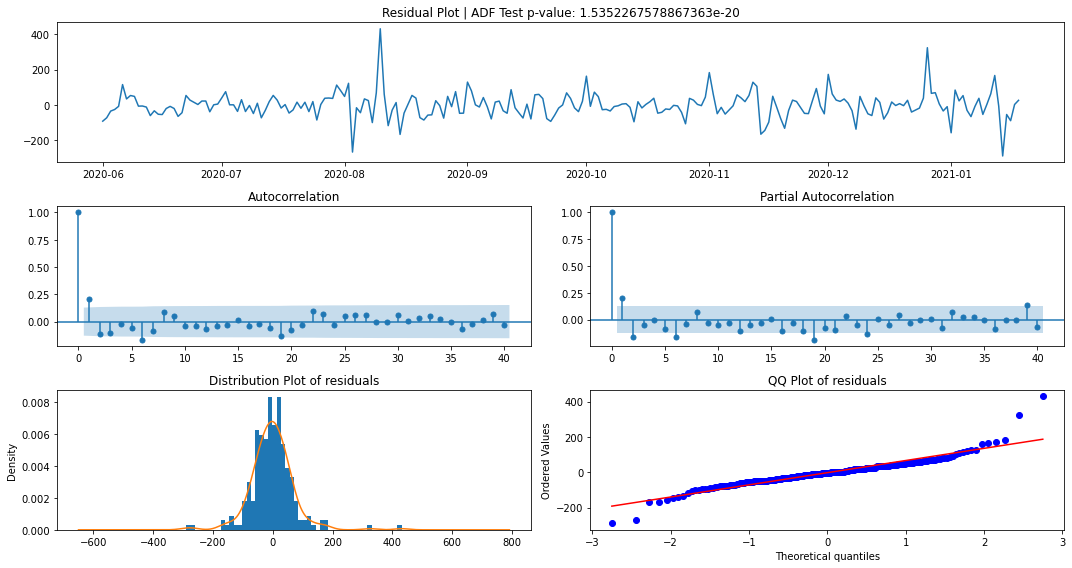

In [211]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train.values,
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=hwes1.index,y=hwes1.values,opacity=0.8,
                    mode='lines',
                    name='predicted'))
fig.add_trace(go.Scatter(x=valid.index,y=valid.values,opacity=0.6,
                    mode='lines',
                    name='test'))
fig.update_layout(height=400,
                 title=f'Triple Exponential Smoothing Fit (Holt-Winters)')
fig.show()
resid_summary(hwes.resid)

In [212]:
model_compare_list.append(['Triple Exponential', *get_metrics(valid,hwes1)])
model_compare_list[-1]

['Triple Exponential', 93.35258016515961, 12.125136997475888]

In [213]:
#much better

## AR-MA Family

In [214]:
#ar-ma models can work best on stationary timeseries

### Check Stationarity

In [215]:

def test_stationarity(train):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index,y=train.values,
                        mode='lines',
                        name='Original'))
    fig.update_layout(height=400,
                     title='Original Data')
    fig.show()
    
    plt.figure(figsize=(15,8))
    plt.subplot(211)
    plot_acf(train, ax=plt.gca(),lags=60) 
    plt.title('AutoCorrelation')
    plt.subplot(212)
    plot_pacf(train, ax=plt.gca(),lags=60) 
    plt.title('Partial AutoCorrelation')
    plt.show()

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(train)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# H0: series is nonstationary
# H1: series is stationary

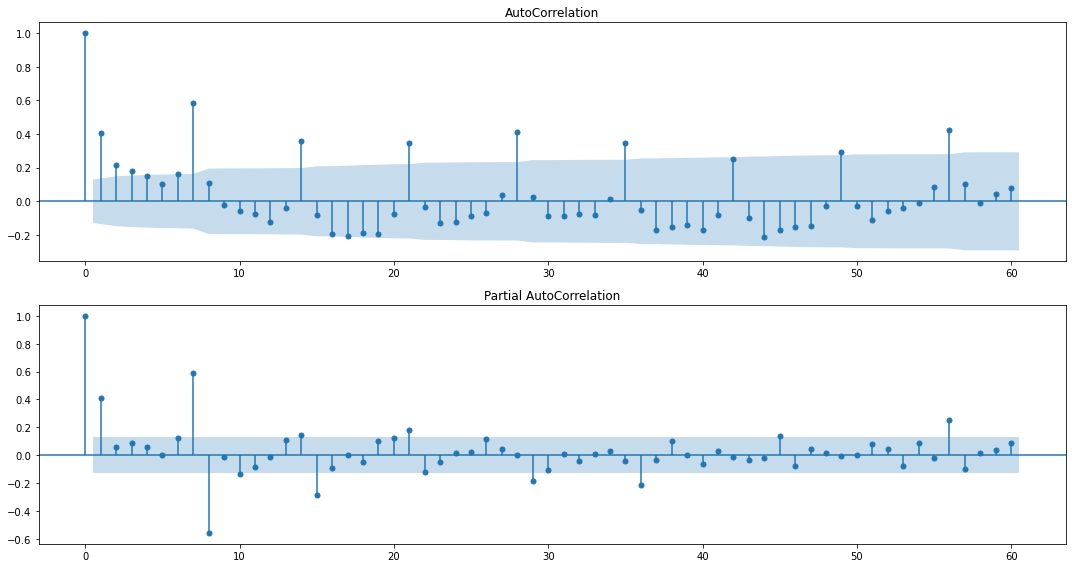

Results of Dickey-Fuller Test:
Test Statistic                  -3.835932
p-value                          0.002560
#Lags Used                      14.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [216]:
test_stationarity(train)

#### as per the test p_value<0.05 
- Surprisingly, the initial series are stationary; the Dickey-Fuller test rejected the null hypothesis that series is non-stationary. Actually, we can see this on the plot itself -- we do not have a visible trend but mainly cyclicity (was evident in stl decomposition).
- From ACF we can clearly see seasonality along with varying amplitude, which we have to deal with prior to modeling. To do so, we take the "seasonal difference", which means a subtraction of the series from itself with a lag that equals the seasonal period.

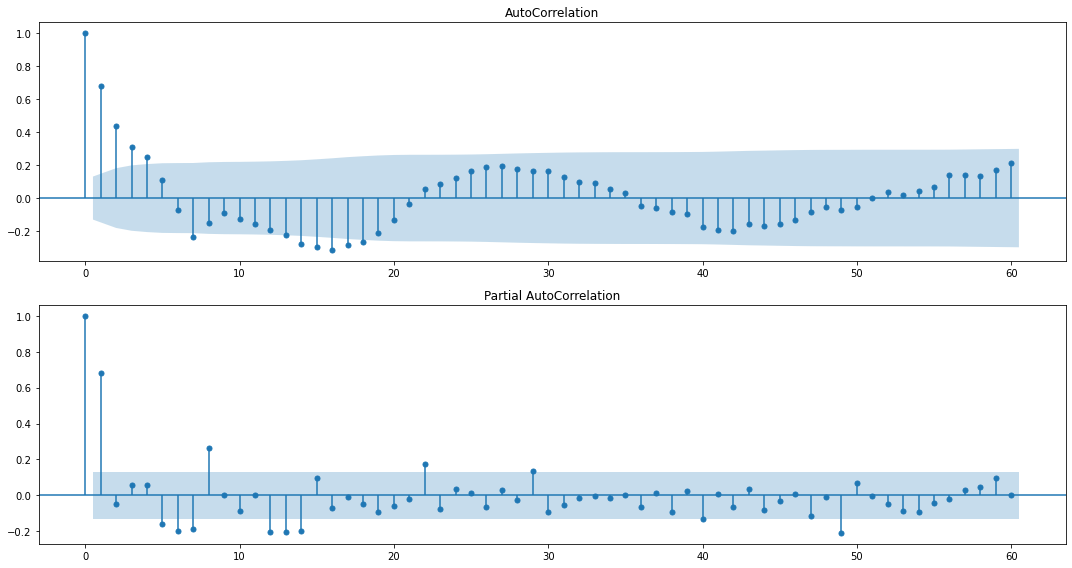

Results of Dickey-Fuller Test:
Test Statistic                  -5.190583
p-value                          0.000009
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


In [217]:
test_stationarity(diff7) # seasonal lagged series (window=7) i.e seasonality removed

- It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

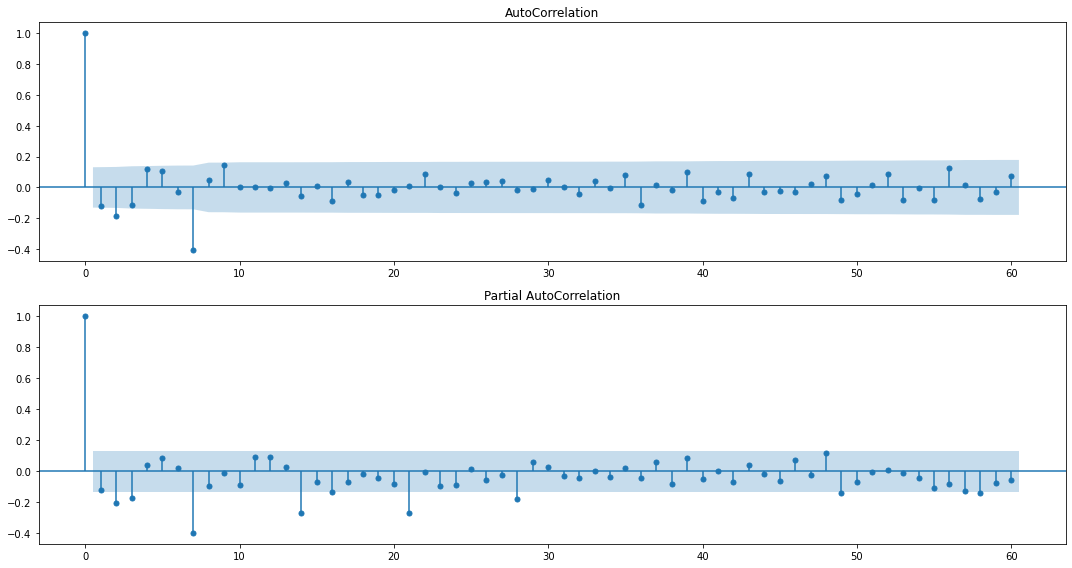

Results of Dickey-Fuller Test:
Test Statistic                -5.723836e+00
p-value                        6.843414e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


In [218]:
diff7_1 = diff7.diff(1).dropna() #remove trend-cycle 
test_stationarity(diff7_1)

#### Data looks like a noise now , 
- Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the number of significant peaks in ACF has dropped. We can finally start modeling!
- we can fit AR-MA on this residual data but we will use wrappers which will handle this trend and seasonality for us i.e ARIMA and SARIMA

So, for ARIMA and SARIMA modelling
- d equals 1 because we had first differences
- s will be 7 (seasonality)
- D again equals 1 because we performed seasonal differentiation once

### ARIMA with manually removing seasonality

In [219]:
from itertools import product 
from tqdm.notebook import tqdm

In [220]:
import warnings
warnings.filterwarnings('ignore')

In [221]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [222]:
# setting initial values and some bounds for them
ps = range(0, 7)
d = 1
qs = range(0, 7)
# creating list with all the possible combinations of parameters
params_arima = product(ps, qs)
params_arima_list = list(params_arima)
len(params_arima_list)

49

In [223]:
def optimizeARIMA(parameters_list, d):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q) tuples
        d - integration order in ARIMA model
    """
    
    results = []

    for param in tqdm(parameters_list):
        p, q = param
        model = STLForecast(train, 
                   ARIMA, 
                   model_kwargs=dict(order=(p,d,q),enforce_stationarity=False)).fit()

            
        f = model.forecast(len(valid))
        rmse = get_metrics(valid,f)[0]
        results.append([param, rmse])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'rmse']
    result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)

    return result_table

In [113]:
result_table = optimizeARIMA(params_arima_list, d)

  0%|          | 0/49 [00:00<?, ?it/s]

In [114]:
result_table.head()

,parameters,rmse
0,"(1, 1)",97.536642
1,"(6, 1)",97.913529
2,"(5, 3)",98.564761
3,"(6, 0)",100.465325
4,"(4, 2)",100.510255


In [224]:
# set the parameters that give the lowest RMSE
p, q = result_table.parameters[0]
best_model = STLForecast(train, ARIMA, model_kwargs=dict(order=(p,d,q),enforce_stationarity=False)).fit()
forecast = best_model.forecast(len(valid))
print(best_model.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  232
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1232.619
Date:                Sun, 22 Aug 2021   AIC                           2471.237
Time:                        13:58:53   BIC                           2481.538
Sample:                    06-01-2020   HQIC                          2475.393
                         - 01-18-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8310      0.042     19.635      0.000       0.748       0.914
ma.L1         -0.9909      0.035    -28.148      0.000      -1.060      -0.922
sigma2      2732.2140    145.860     18.732      0.0

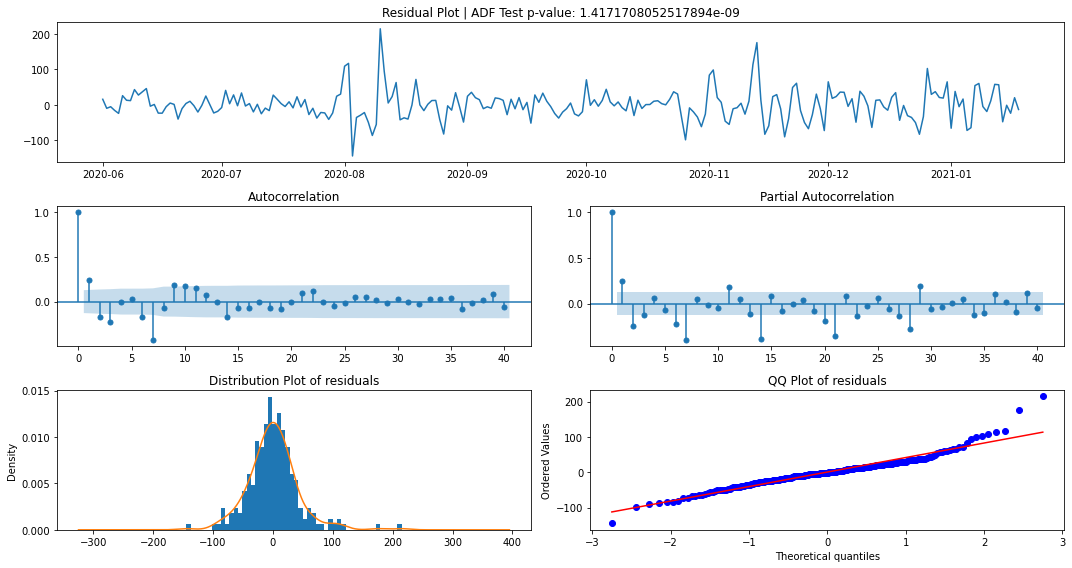

In [225]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train.values,
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=valid.index,y=forecast,opacity=0.8,
                    mode='lines',
                    name='predicted'))
fig.add_trace(go.Scatter(x=valid.index,y=valid.values,opacity=0.6,
                    mode='lines',
                    name='valid'))
fig.update_layout(height=400,
                 title='ARIMA forecasting')
fig.show()
resid_summary(best_model.result.resid)

In [226]:
model_compare_list.append(['ARIMA (lag7)', *get_metrics(valid,forecast)])
model_compare_list[-1]

['ARIMA (lag7)', 97.53664249075953, 11.73092073588166]

### SARIMA with D=1, s=7 and d=1

In [227]:
import statsmodels.api as sm

In [228]:
ps = range(0, 4)
d = 1
qs = range(0, 4)
s = 7 # season length 
Ps = range(0, 4)
D = 1
Qs = range(0, 4)

# creating list with all the possible combinations of parameters
params_sarima = product(ps, qs, Ps, Qs)
params_sarima_list = list(params_sarima)
len(params_sarima_list)

256

In [229]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, d, q, P, D, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []

    
    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        p,q,P,Q = param
        model = sm.tsa.SARIMAX(train, order=(p, d, q), 
                                 seasonal_order=(P, D, Q, s), enforce_stationarity=False).fit()

        f = model.forecast(len(valid))
        rmse = get_metrics(valid,f)[0]
        results.append([param, rmse])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'rmse']
    result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)

    return result_table

In [53]:
result_table = optimizeSARIMA(params_sarima_list, d, D, s)


  0%|          | 0/256 [00:00<?, ?it/s]

In [54]:
result_table.head(5)

,parameters,rmse
0,"(1, 1, 3, 3)",63.272627
1,"(2, 1, 3, 3)",63.344963
2,"(1, 2, 2, 3)",66.238937
3,"(3, 3, 0, 2)",70.642007
4,"(1, 1, 1, 2)",70.987371


In [230]:
# set the parameters that give the lowest RMSE
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s), enforce_stationarity=False).fit()
forecast = best_model.forecast(len(valid))
print(best_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                     Value   No. Observations:                  232
Model:             SARIMAX(1, 1, 1)x(3, 1, [1, 2, 3], 7)   Log Likelihood               -1147.323
Date:                                   Sun, 22 Aug 2021   AIC                           2312.646
Time:                                           13:59:27   BIC                           2342.376
Sample:                                       06-01-2020   HQIC                          2324.676
                                            - 01-18-2021                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6719      0.072      9.322      0.000    

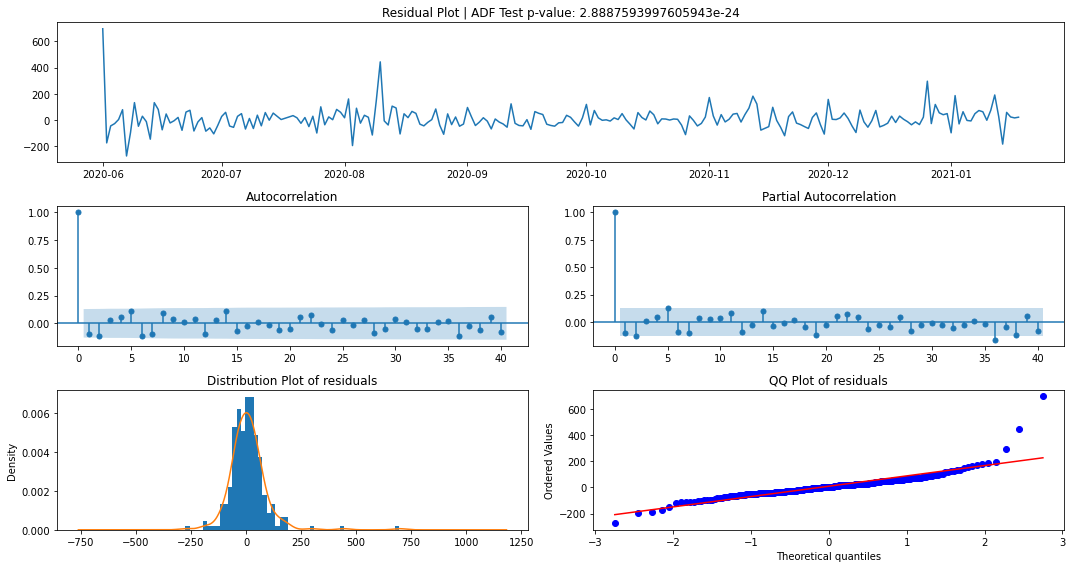

In [231]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train.values,
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=valid.index,y=forecast,opacity=0.8,
                    mode='lines',
                    name='predicted'))
fig.add_trace(go.Scatter(x=valid.index,y=valid.values,opacity=0.6,
                    mode='lines',
                    name='valid'))
fig.update_layout(height=400,
                 title='SARIMAX forecasting')
fig.show()
resid_summary(best_model.resid)

In [232]:
model_compare_list.append(['SARIMAX', *get_metrics(valid,forecast)])
model_compare_list[-1] 

['SARIMAX', 63.27262684768035, 7.851562609697639]

## Model Comparison

In [233]:
model_compare_table = pd.DataFrame(model_compare_list,columns=['model','RMSE','MAPE'])
model_compare_table = model_compare_table.sort_values('RMSE', ascending=False)
model_compare_table['RMSE'] = np.round(model_compare_table['RMSE'],2)
model_compare_table['MAPE'] = np.round(model_compare_table['MAPE'],2)

In [234]:
fig = px.bar(model_compare_table, y='model', x='RMSE',color='RMSE', text='RMSE',
            title='Validation RMSE Scores of various models')
fig.show()
fig = px.bar(model_compare_table, y='model', x='MAPE',color='MAPE', text='MAPE',
            title='Validation MAPE Scores of various models')
fig.show()

In [235]:
# we will use SARIMAX as our final model

In [236]:
train_val = pd.concat([train,valid]) #combine train and valid

In [237]:
p, q, P, Q = result_table.parameters[0]
final_model = sm.tsa.statespace.SARIMAX(train_val, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit()
forecast_test = final_model.forecast(len(test))
print(final_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                     Value   No. Observations:                  277
Model:             SARIMAX(1, 1, 1)x(3, 1, [1, 2, 3], 7)   Log Likelihood               -1518.974
Date:                                   Sun, 22 Aug 2021   AIC                           3055.948
Time:                                           13:59:51   BIC                           3088.300
Sample:                                       06-01-2020   HQIC                          3068.941
                                            - 03-04-2021                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6713      0.051     13.153      0.000    

In [238]:
get_metrics(forecast_test,test) #rmse and mape on test set using final model

(151.7344268455022, 18.189573207550577)

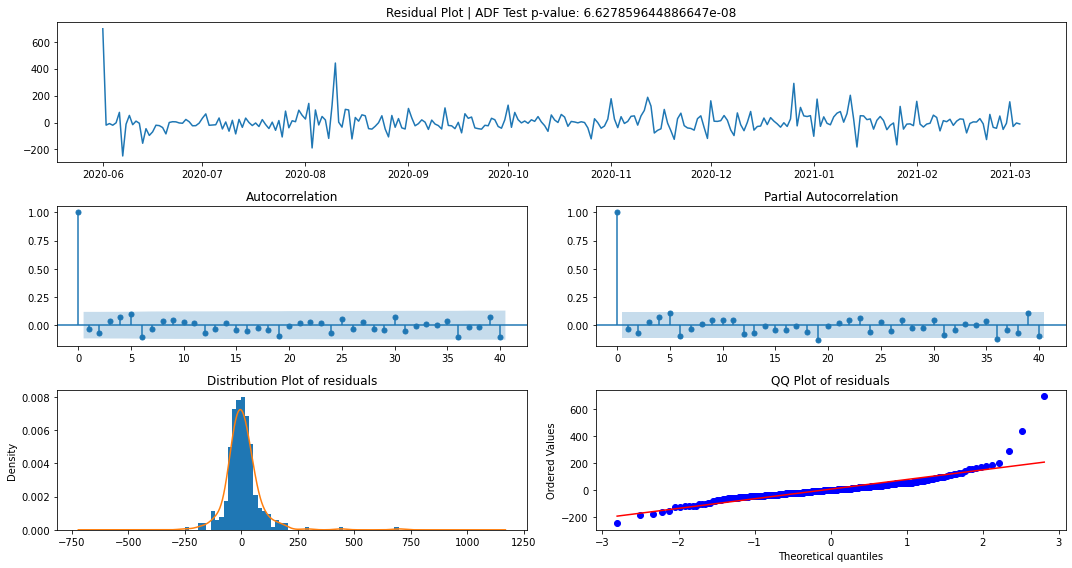

In [239]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_val.index,y=train_val.values,
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=test.index,y=forecast_test,opacity=0.8,
                    mode='lines',
                    name='predicted'))
fig.add_trace(go.Scatter(x=test.index,y=test.values,opacity=0.8,
                    mode='lines',
                    name='test'))
fig.update_layout(height=400,
                 title=f'Final Model Result on Test set')
fig.show()
resid_summary(final_model.resid)

In final model: 
- residual have constant variance (homoscedasticity)
- No residual auto-correlation
- residual have 0 mean 
- residuals are normally distributed

## Conclusion :

- From all the models that were tested in this Analysis we found that SARIMAX performed best and  gave the least Percentage error on validation data and gave MEAN ABSOLUTE PERCENTAGE ERROR of 18% and rmse of 151 crore on test set

## Future Work :

- we wish to try more sofisticated models like Deep learning based LSTM and facebook prophet which can give significantly better results 